In [1]:
!pip3 install -q --upgrade --user git+https://github.com/pymc-devs/pymc4.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [0]:
@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = yield pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = yield pm.Normal('mu_beta', mu=0., sigma=1)
    sigma_b = yield pm.HalfCauchy('sigma_beta', beta=1)

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal('alpha', mu=mu_a, sigma=sigma_a, plate=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal('beta', mu=mu_b, sigma=sigma_b, plate=len(data.county.unique()))

    # Model error
    eps = yield pm.HalfCauchy('eps', beta=1)

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal('y_like', mu=radon_est, sigma=eps, observed=data.log_radon)

In [4]:
%%time
init_num_chains = 50
model = hierarchical_model(data, county_idx)
pm4_trace, _ = pm.inference.sampling.sample(
    model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=True)

CPU times: user 35.5 s, sys: 4.93 s, total: 40.5 s
Wall time: 41.8 s


### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [5]:
%%time
for i in range(3):
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
        step_size=step_size_, xla=True)

CPU times: user 1min 18s, sys: 5.2 s, total: 1min 23s
Wall time: 1min 26s


Finally get samples for inference:

In [6]:
%%time
num_chains = 5
step_size_ = []
for _, x in pm4_trace.items():
    std = tf.math.reduce_std(x, axis=[0, 1])
    step_size_.append(
        std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

pm4_trace, sample_stat = pm.inference.sampling.sample(
    model, num_chains=num_chains, num_samples=500, burn_in=500,
    step_size=step_size_, xla=True)

CPU times: user 45.1 s, sys: 7.75 s, total: 52.8 s
Wall time: 53.7 s


In [0]:
az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)

In [8]:
np.mean(np.exp(az_trace.sample_stats['mean_tree_accept']), axis=1)

<xarray.DataArray 'mean_tree_accept' (chain: 5)>
array([0.766164, 0.808744, 0.810793, 0.704086, 0.587775], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4

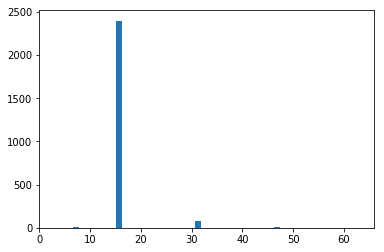

In [9]:
plt.hist(np.ravel(az_trace.sample_stats['tree_size']), 50);

In [10]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/mu_alpha,1.489,0.050,1.395,1.578,0.002,0.001,660.0,660.0,654.0,1017.0,1.01
hierarchical_model/__log_sigma_alpha,-1.139,0.139,-1.413,-0.887,0.005,0.004,710.0,694.0,724.0,988.0,1.01
hierarchical_model/__log_eps,-0.328,0.026,-0.372,-0.281,0.001,0.001,493.0,493.0,509.0,976.0,1.01
hierarchical_model/alpha[0],1.209,0.232,0.791,1.666,0.005,0.003,2203.0,2203.0,2187.0,1769.0,1.01
hierarchical_model/alpha[1],0.990,0.099,0.807,1.177,0.002,0.002,2008.0,2006.0,2044.0,1713.0,1.00
hierarchical_model/alpha[2],1.496,0.269,0.992,1.989,0.009,0.006,906.0,906.0,897.0,878.0,1.01
hierarchical_model/alpha[3],1.538,0.227,1.141,1.966,0.011,0.008,433.0,430.0,439.0,1739.0,1.01
hierarchical_model/alpha[4],1.476,0.237,1.025,1.898,0.005,0.004,1986.0,1886.0,1997.0,1508.0,1.01
hierarchical_model/alpha[5],1.505,0.251,1.025,1.953,0.008,0.006,1002.0,946.0,1005.0,1413.0,1.00
hierarchical_model/alpha[6],1.864,0.173,1.529,2.185,0.006,0.004,791.0,763.0,797.0,936.0,1.00


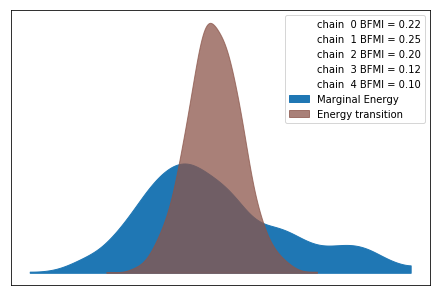

In [11]:
az.plot_energy(az_trace);

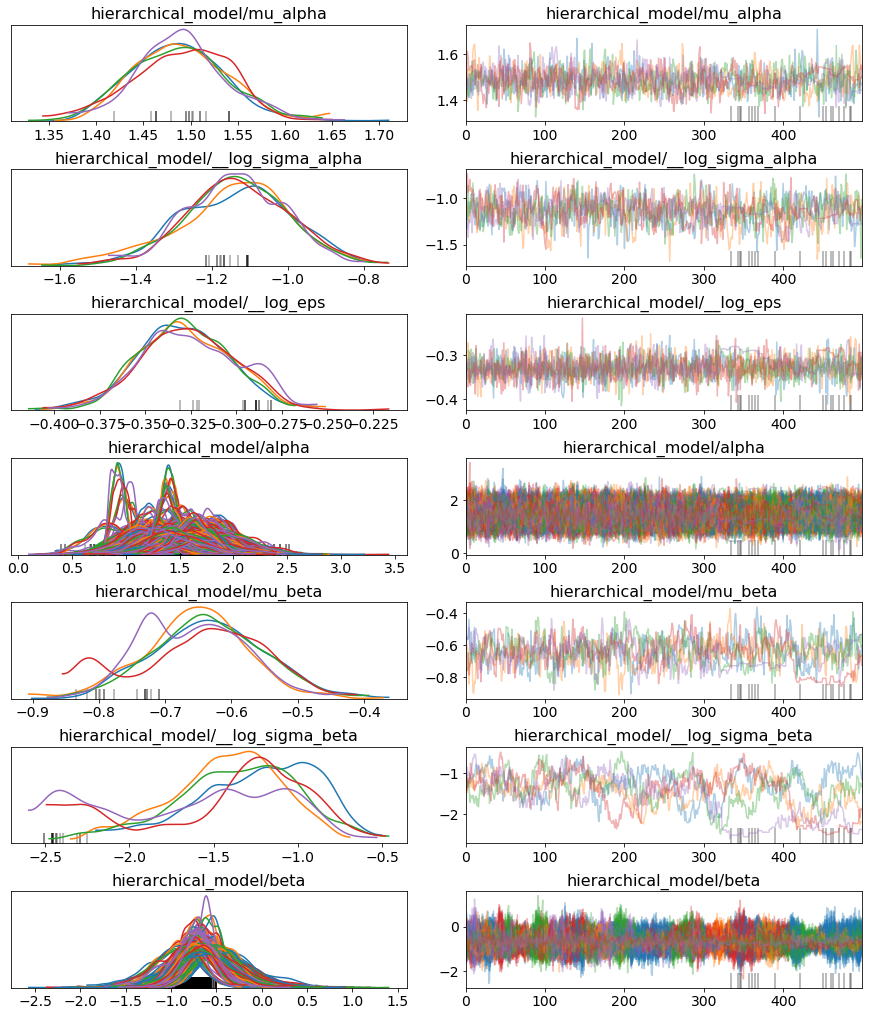

In [13]:
az.plot_trace(az_trace, compact=True);